In [104]:
from brian2 import *
import csv
import numpy as np
import os

In [105]:
#Test read one file
file = []
# with open("dataset/left_hand_A2_V1.csv") as csvfile:
with open("test.csv") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader: # each row is a list
        file.append(row)
file = np.array(file).astype(int)

In [106]:
dataset = []
labels = []

for filename in os.listdir("dataset/"):
   labels.append(filename.split('_')[0])
   data = []
   with open(f"dataset/{filename}", 'r') as csvfile:
      reader = csv.reader(csvfile)
      for row in reader: # each row is a list
        data.append(row)

   dataset.append(np.array(data).astype(int))

dataset = np.array(dataset)

WARNING    C:\Users\isakl\AppData\Local\Temp\ipykernel_51660\168832076.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)
 [py.warnings]


In [107]:
dataset.shape

(40,)

In [108]:
# Code from documentation with TimedArray
# start_scope()
# ta2d = TimedArray([[1, 2], [3, 4], [5, 6]]*mV, dt=0.1*ms)
# G = NeuronGroup(4, 'v = ta2d(t, i%2) : volt')
# mon = StateMonitor(G, 'v', record=True)
# net = Network(G, mon)
# net.run(0.2*ms)  

# print(mon.v[:])

In [109]:
#Test to take the test file and set every frame as an input with 0.1ms delay
# start_scope()
# ta2d = TimedArray(file*mV, dt=0.1*ms)
# G = NeuronGroup(num_inputs, 'v = ta2d(t, i) : volt')
# mon = StateMonitor(G, 'v', record=True)
# net = Network(G, mon)
# net.run(5*ms)

# # monitor the 4th neurons voltage
# print(mon.v[3])

# plot(mon.t/ms, mon.v[3])
# xlabel('Time (ms)')
# ylabel('v');

In [110]:
# Test create the timedarray as the current at each time step
# start_scope()
# tau = 0.2*ms
# I_recorded = TimedArray(file, dt=0.1*ms)
# eqs = '''
# dv/dt = (I-v)/tau : 1
# I = I_recorded(t, i) : 1
# '''
# G = NeuronGroup(num_inputs, eqs, threshold='v>0.3', reset='v=0', method='exact')
# M = StateMonitor(G, variables=True, record=True)
# run(5*ms)

# plot(M.t/ms, M.v[3], label='v')
# plot(M.t/ms, M.I[3], label='I')
# xlabel('Time (ms)')
# ylabel('v')
# legend(loc='best');

In [111]:
frame_delay = 20*ms

# Extract the which neurons spikes and at which times they spike
def extract_spikes(file):
    spikes_indices = []
    spikes_times = []

    frame_count = 1

    for frame in file:
        for index in range(len(frame)):
            if frame[index] > 0:
                # print(index, frame_count*dt)
                spikes_indices.append(index)
                spikes_times.append(frame_count*frame_delay)
        frame_count += 1
        
    return spikes_indices, spikes_times

In [112]:
spike_dataset = []
for data in dataset:
    spikes_indices, spikes_times = extract_spikes(data)
    spike_dataset.append((spikes_indices, spikes_times))

In [113]:
# #Test to take the test file and set every frame as an input with 0.1ms delay
# start_scope()
# SGG = SpikeGeneratorGroup(num_inputs, spikes_indices, spikes_times)
# M = SpikeMonitor(SGG)
# run(5000*ms)

# print('Spike times: %s' % M.t[:])

In [114]:
# plot the spikes neurons create (should be the same as the csv file)
# figure(figsize=(10,2))
# plot(M.i, -M.t/ms, 'o', label='spike', markersize=0.5)
# ylim(-3, 0)
# xlabel('neuron id')
# ylabel('Time (ms)')
# legend(loc='best')

In [115]:
# zoom in on the first 30 neurons
# figure(figsize=(5,5))
# plot(M.i, -M.t/ms, 'o', label='spike', markersize=2)
# ylim(-3, 0)
# xlim(0, 30)
# xlabel('neuron id')
# ylabel('Time (ms)')
# legend(loc='best')

In [116]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [117]:
start_scope()

# Neuron paramenters
num_inputs = 100

#####
num_hidden = 20

tau_mem = 20*ms
tau_syn = 2*ms
v_rest = -70*mV
R = 100*Mohm
I_weight = 5*nA
eqs = '''
dv/dt = (v_rest - v + R*I_syn) / tau_mem : volt (unless refractory)
dI_syn/dt = -I_syn/tau_syn : ampere
'''
thres = 'v>-55*mV'
reset = 'v=-80*mV'
refract_time = 2*ms

# Init Neuron layers
Input = SpikeGeneratorGroup(num_inputs, [0], [0*ms]) # a dummy input as set set the inout for each train/test sample

#####
Hidden = NeuronGroup(num_hidden, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')

Inhib = NeuronGroup(2, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
Output = NeuronGroup(2, eqs, threshold=thres, reset=reset, refractory=refract_time, method='exact')
# 
# Set neuron voltage to resting before running the simulation

######
Hidden.v = v_rest
Inhib.v = v_rest
Output.v = v_rest

# Synapse parameters
taupre = taupost = 20*ms
wmax = 1000 * pA
wmin = 0 * pA
Apre = 1 * mA
Apost = -Apre*taupre/taupost*1.05


#######
# Create synapses
InputToHidden = Synapses(Input, Hidden, '''
                        w : ampere
                        dapre/dt = -apre/taupre : ampere (event-driven)
                        dapost/dt = -apost/taupost : ampere (event-driven)
                        ''',
                        on_pre='''
                        I_syn_post += w
                        apre += Apre
                        w = clip(w+apost, wmin, wmax)
                        ''',
                        on_post='''
                        apost += Apost
                        w = clip(w+apre, wmin, wmax)
                        ''', method='linear')
InputToHidden.connect()
InputToHidden.w = 'rand() * wmax'

HiddenToOutput = Synapses(Hidden, Output, '''
                        w : ampere
                        dapre/dt = -apre/taupre : ampere (event-driven)
                        dapost/dt = -apost/taupost : ampere (event-driven)
                        ''',
                        on_pre='''
                        I_syn_post += w
                        apre += Apre
                        w = clip(w+apost, wmin, wmax)
                        ''',
                        on_post='''
                        apost += Apost
                        w = clip(w+apre, wmin, wmax)
                        ''', method='linear')
HiddenToOutput.connect()
HiddenToOutput.w = 'rand() * wmax'

##############

# InputToOutput = Synapses(Input, Output, '''
#                         w : ampere
#                         dapre/dt = -apre/taupre : ampere (event-driven)
#                         dapost/dt = -apost/taupost : ampere (event-driven)
#                         ''',
#                         on_pre='''
#                         I_syn_post += w
#                         apre += Apre
#                         w = clip(w+apost, wmin, wmax)
#                         ''',
#                         on_post='''
#                         apost += Apost
#                         w = clip(w+apre, wmin, wmax)
#                         ''', method='linear')
# InputToOutput.connect()
# InputToOutput.w = 'rand() * wmax'



OutputToInhib = Synapses(Output, Inhib, on_pre='I_syn += I_weight/2')
OutputToInhib.connect(condition='i==j')

InhibToOutput = Synapses(Inhib, Output,'switch : 1' , on_pre='I_syn += -I_weight * switch')
InhibToOutput.connect(condition='i!=j')

monitorSpikes = SpikeMonitor(Input)
monitorHidden = StateMonitor(Hidden, ['v', 'I_syn'], record=True)
monitorOutput = StateMonitor(Output, ['v', 'I_syn'], record=True)
monitorInhib = StateMonitor(Inhib, ['v', 'I_syn'], record=True)
monitorSynapses = StateMonitor(InputToHidden, ['w', 'apre', 'apost'], record=True)


network = Network(Input, Hidden, Output, Inhib, InputToHidden, HiddenToOutput, OutputToInhib, InhibToOutput, monitorSpikes, monitorHidden, monitorOutput, monitorInhib, monitorSynapses)

# visualise_connectivity(InputToOutput)

network.store

run_to = 0*ms

index_list = []

for index in range(20):
    index_list.append(index)
    index_list.append(index+20)

for index in index_list:

    network.restore

    Input.set_spikes(spike_dataset[index][0], spike_dataset[index][1] + run_to)

    Hidden.v = v_rest
    Inhib.v = v_rest
    Output.v = v_rest

    Hidden.I_syn = 0
    Inhib.I_syn = 0
    Output.I_syn = 0

    if index < 20:
        InhibToOutput.switch[0] = 0
        InhibToOutput.switch[1] = 1
    else:
        InhibToOutput.switch[0] = 1
        InhibToOutput.switch[1] = 0

    print(f"Running training sample {index} \t {network.t}")

    run_time = frame_delay * len(dataset[index])
    run_to += run_time

    network.run(run_time)
    
    network.store

# print("ran")

# network.restore

# Input = SpikeGeneratorGroup(num_inputs, [1], [1*ms])
# network = Network(Input, Output, Inhib, InputToOutput, OutputToInhib, InhibToOutput, monitorSpikes, monitorOutput, monitorInhib, monitorSynapses)

# network.run(frame_delay * len(file))


# plot(monitorSpikes.t/ms, monitorSpikes.i, '.k')
# xlabel('Time (ms)')
# ylabel('Neuron index');



# figure(figsize=(4, 8))
# subplot(211)
# plot(monitorSynapses.t/ms, monitorSynapses.apre[0], label='apre')
# plot(monitorSynapses.t/ms, monitorSynapses.apost[0], label='apost')
# legend()
# subplot(212)
# plot(monitorSynapses.t/ms, monitorSynapses.w[0], label='w')
# legend(loc='best')
# xlabel('Time (ms)');


Running training sample 0 	 0. s
Running training sample 20 	 0.44 s
Running training sample 1 	 1.06 s
Running training sample 21 	 1.56 s
Running training sample 2 	 1.96 s
Running training sample 22 	 2.5 s
Running training sample 3 	 2.84 s
Running training sample 23 	 3.42 s
Running training sample 4 	 3.84 s
Running training sample 24 	 4.38 s
Running training sample 5 	 4.78 s
Running training sample 25 	 5.38 s
Running training sample 6 	 5.88 s
Running training sample 26 	 6.3 s
Running training sample 7 	 6.78 s
Running training sample 27 	 7.3 s
Running training sample 8 	 7.9 s
Running training sample 28 	 8.44 s
Running training sample 9 	 8.96 s
Running training sample 29 	 9.48 s
Running training sample 10 	 9.94 s
Running training sample 30 	 10.62 s
Running training sample 11 	 11.14 s
Running training sample 31 	 11.82 s
Running training sample 12 	 12.48 s
Running training sample 32 	 13.34 s
Running training sample 13 	 14.14 s
Running training sample 33 	 14.98 s
R

In [118]:
# Try test one
network.restore

Input.set_spikes(spike_dataset[0][0], spike_dataset[0][1] + run_to)

Hidden.v = v_rest
Inhib.v = v_rest
Output.v = v_rest

Hidden.I_syn = 0
Inhib.I_syn = 0
Output.I_syn = 0

InhibToOutput.switch[0] = 0
InhibToOutput.switch[1] = 0

print(f"Running test: {network.t}")

run_time = frame_delay * len(dataset[38])
run_to += run_time

monitorTestSpikes = SpikeMonitor(Output)

network.add(monitorTestSpikes)

network.run(run_time)


Running test: 20.34 s


In [119]:
monitorTestSpikes.i

<spikemonitor_1.i: array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])>

In [120]:
unique, counts = numpy.unique(monitorTestSpikes.i, return_counts=True)
dict(zip(unique, counts))

{0: 31, 1: 31}

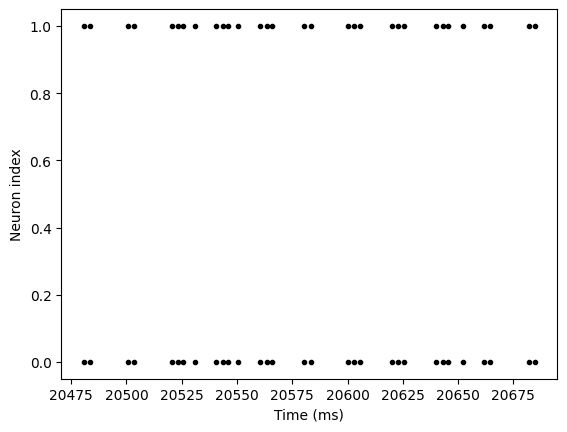

In [121]:
plot(monitorTestSpikes.t/ms, monitorTestSpikes.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [122]:
# monitorSynapses.w
# visualise_connectivity(OutputToInhib)

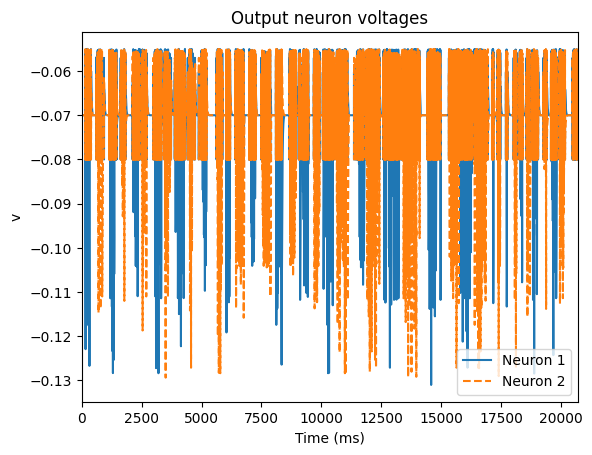

In [123]:
plot(monitorOutput.t/ms, monitorOutput.v[0], label='Neuron 1')
plot(monitorOutput.t/ms, monitorOutput.v[1], '--',label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Output neuron voltages')
xlim(0,run_to/ms)
legend();

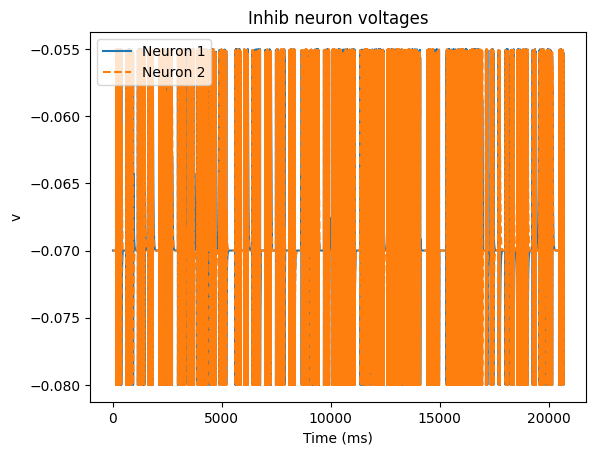

In [124]:
plot(monitorInhib.t/ms, monitorInhib.v[0], label='Neuron 1')
plot(monitorInhib.t/ms, monitorInhib.v[1], '--', label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Inhib neuron voltages')
legend();

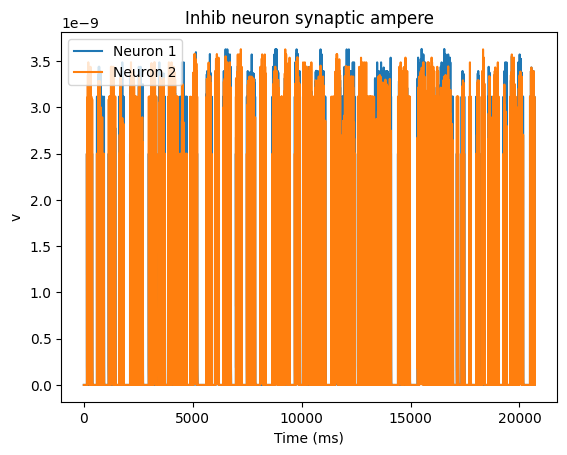

In [125]:
plot(monitorInhib.t/ms, monitorInhib.I_syn[0], label='Neuron 1')
plot(monitorInhib.t/ms, monitorInhib.I_syn[1], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Inhib neuron synaptic ampere')
legend();

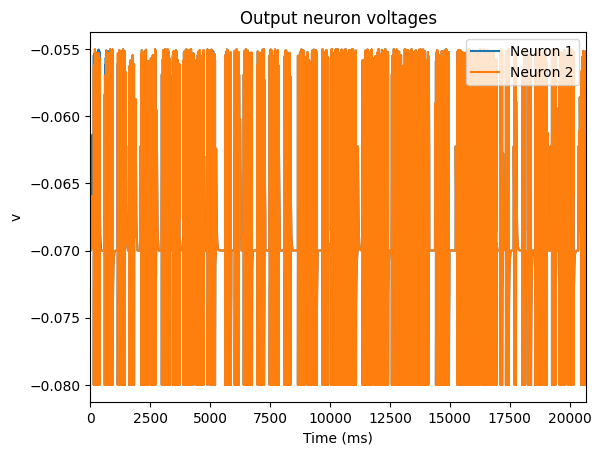

In [126]:
plot(monitorHidden.t/ms, monitorHidden.v[0], label='Neuron 1')
plot(monitorHidden.t/ms, monitorHidden.v[1], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
title('Output neuron voltages')
xlim(0,run_to/ms)
legend();